<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <a href="" target="_blank">
  <img alt='Thumbnail for a video showing 3 cool Google Colab features' src="https://lh3.googleusercontent.com/8f6KyXu7OCkY5E4BC1v7kgFbzpscRsT326y8SwrClbMc3ptYRqMHcccIituJQOivN4iP4xCNGbVKLatIvLfnwOEdaJTxNf1YDViDy35FeXh8daUdOyxOqGr0DgLtUoAteTNlqLwneRo24R7JY84i7SebCYo4F5TtmFHA3wsmDS-RIYyAFkmhTEsT4QKR0BvKW6lYnwNy_pjAMXL35JGIchtBFfIFsIzGVKtZLldsOmbFb3D_Ly71HmQvy2zi3xSwe_PLs8aUZ4BjR4sorbomNULOKh6zave_pL0O559h4gcs-r2U5AZLRJaxS-SXhFfUhEPC6I0WPJW3IFpDOqZFP7HFVUPyXwbWvh8jTtl8_hBOJW1GeD7xBqojQxEykMVa7tCIEhbA8izuXVhFZF88qvqFVsspfbtN6Cy3_wL3ksVrzXg-PJ1dXDPvpMwPLxpZV-haviWEuPxDtT_weV6pKgFmEwHmHH9rgPQIXmxStupc-dBGl647taYVeUUmncmTVTIMBBCQMcZByRzf3oKptFwYdGy6Yer-xjYvZ523_VNn4ni_YNU9f4mTaeCKN2AlScHHhrFfDKUTHyuQsbtOjh67GVXSi5j2ibK2Y1VJe7uMr6171k1m232F0d63k4EksMreQRbbVbtflYpcKB7epF1FY6P8SHCWvAKBJjS60joXBYaUdQQly6GreRAtnKkokfy9LJVfn7kC_0nyT0Eth4g_Y1GN3LyHPrmr3dHqrz38B3kaDpsdoyeM5ZGYeglPTz2UKbgHtLXVrK-cfnfORxQf8Ax4jK-VQtxx_v6d6MHPGd18KaSfGRdvYI-EGpIohPLWYlIfvjyuNylJKUU7rWBXHw0vNfHdvtiiI_dw9ZIiY84OqtXRubBPAPMFz--fvZWi17cBDpKOTR-BeK_SJautIcIA3P8QxhimZTw4C3pEIxnouQy22cuUtth2OKkPtTG4lgJIubSPYKxVN9ppVECJRZSefLOBV2giOWgJyZW-Xgr3VygyB2A9=w1658-h269-no?authuser=1" >
  </a>
</center>



# Code

In [32]:
from google.colab import drive
drive.mount('/content/drive')
import scipy
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns

from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
def loadfile(filepath):
    img = io.imread(filepath, as_gray=True)
    img = np.array(img).astype(np.int32)
    txtfile= filepath.split('.')[0]+'.txt'
    with open(txtfile,'r') as txt_file:
        txt = txt_file.read()
        del txt_file
        txt=txt.split('\n')
        txt=txt[1:-1]
        sem_dict = {}
        for row in txt:
            row = row.split('=')
            sem_dict.update({row[0]:  row[1]}) 
        width, height = sem_dict['DataSize'].split('x')
        width, height = int(width), int(height)
        if height == 1920:
            img = img[0:1780,0:2560]
            height = 1780
        pixelsize = float(sem_dict['PixelSize'])
        #print('FILE NAME:',sem_dict['ImageName'])
        #print('DATE:',sem_dict['Date'] )   
        #print('IMAGE SIZE [pixels]:', width,'x',height) 
        #print('PIXEL SIZE [nm]:', sem_dict['PixelSize'],)

        #print('IMAGE SIZE [nm]:', 
        #    round(width*float(sem_dict['PixelSize']),0), 
        #    'x',
         #   round(height*float(sem_dict['PixelSize']),0))
        #print('IMAGE AREA [nm]:', width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize']))
        image_area = width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize'])
    textstr = '\n'.join((
        'FILE NAME: '+sem_dict['ImageName'],
        'PIXEL SIZE [nm]: '+str(round(float(sem_dict['PixelSize']),2)),
        'IMAGE SIZE [nm]: '+str(int(width*float(sem_dict['PixelSize'])))+'x'+str(int(height*float(sem_dict['PixelSize'])))))       
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,vmax=255, cmap='gray')
    plt.text(100, 100, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
    plt.show()
    return img, sem_dict,width, height,pixelsize,image_area

In [34]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()

In [35]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    img2 = denoise_tv_chambolle(img2, weight=6)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.zeros(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                #print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = True
    img2[img2<0] = 0
    mask[0,0:]=True
    mask[-1,0:]=True
    mask[0:,0]=True
    mask[0:,-1]=True
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img2,vmax=img2.max())
    plt.show()
    unique, counts = np.unique(mask, return_counts=True)
    mask_area = dict(zip(unique, counts))
   # print('usable area: ',round(mask_area[False]/(mask_area[True]+mask_area[False]),2))
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(mask)
    plt.show()
    return img2, median_img,mask, mask_area

In [36]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))

In [37]:
def segmentation(low,denoise=6,small=15,erosion=1):
    #img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = clear_border(img_segm,
                          mask=np.invert(scipy.ndimage.morphology.binary_dilation(mask,iterations=1))
                          )
    img_segm = morphology.area_closing(img_segm)
    for i in range(erosion):
        img_segm = morphology.binary_erosion(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    for i in range(erosion-1):     
        img_segm = morphology.binary_dilation(img_segm)
    return img_segm


In [38]:
def label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())
    props = regionprops_table(img2_label, img2,
                           properties=['mean_intensity',
                                       'area',
                                       'extent',
                                       'eccentricity',
                                       'convex_area',
                                       'equivalent_diameter',
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image',
                                       'convex_image'
                                       ]
                              )
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm['convex_perimeter'] = data_nm['convex_image'].apply(lambda x: perimeter(x))
    data_nm = data_nm.drop(columns=[
                                 #   'image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                              #      'img',
                           #         'mean_intensity',
                                  #  'convex_image'
                                    ])
    to_nm = ['equivalent_diameter',
       'major_axis_length', 'minor_axis_length', 'perimeter',
       'feret_diameter_max', 'convex_perimeter']

    to_nm2 = ['area', 'convex_area']
    data_nm['circularity'] = np.sqrt(4*np.pi*data_nm['area']/(data_nm['perimeter'])**2)
    data_nm.loc[data_nm['circularity'] >1 ,'circularity'] = 1
    for column in to_nm:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize)
    for column in to_nm2:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize*pixelsize)
    data_nm['aspect_ratio'] = data_nm['minor_axis_length']/data_nm['major_axis_length']
    data_nm['solidity'] =data_nm['area']/data_nm['convex_area']
    data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'convex_perimeter'] = data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'perimeter'].values
    data_nm['convexity'] = data_nm['convex_perimeter']/data_nm['perimeter']
    data_nm['filename'] = sem_dict['ImageName'].split('.')[0]
    unique, counts = np.unique(mask, return_counts=True)
    
    data_nm['area_fraction']=data_nm['area']*mask_area[False]/(mask_area[True]+mask_area[False])
    csv_file_name=sem_dict['ImageName'].split('.')[0]
    data_nm.to_csv(csv_file_name+'.csv')
    return img2_label, img2_label_overlay, data_nm

In [47]:
def quick_label_img():
    img2_label = label(img_segm)
   # img2_label = clear_border(img2_label)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label)
    props = pd.DataFrame(props)
    return len(props)


# Single File

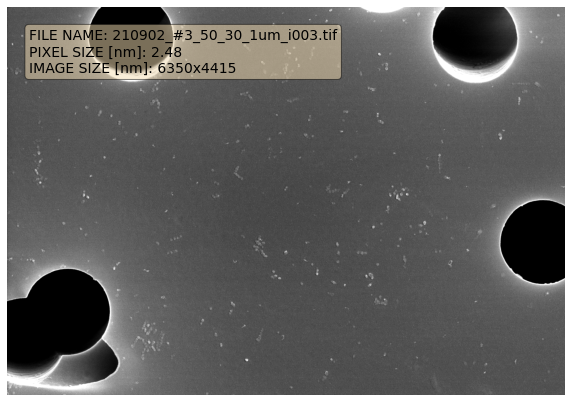

In [25]:
#@title Load File

file_path = '/content/drive/MyDrive/CIOP/images/#50/210902_#3_50_30_1um_i003.tif' #@param {type:"string"}
show_info = False #@param {type:"boolean"}
img,sem_dict,width, height,pixelsize,image_area = loadfile(file_path)
if show_info:
    print(pd.DataFrame(sem_dict,index=[0]).T)

Median Rectangle Box size: 178 x 256
Median intensity: 85.0


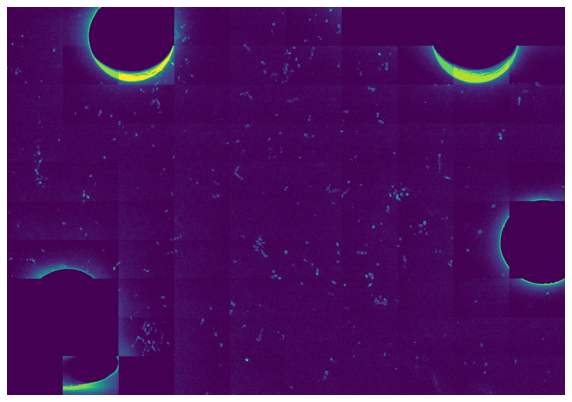

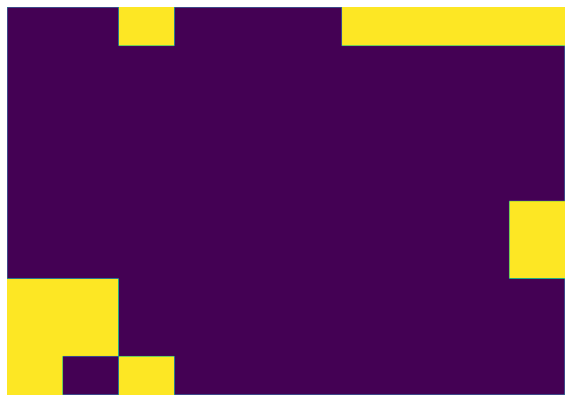

In [41]:
#@title Number of rectangles [x:x]
#@markdown Insert number of rectangles in the image 
number_slider = 10 #@param {type:"slider", min:2, max:50, step:2}
img2, median_img,mask, mask_area = uniform(number_slider,number_slider)

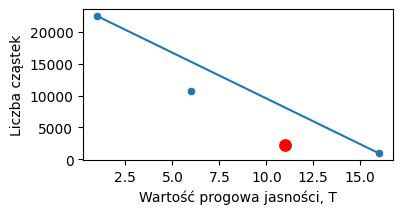

In [226]:
#@title Fit intensity
cut_off_min = 1 #@param {type:"slider", min:0, max:50, step:1}
cut_off_max = 20 #@param {type:"slider", min:0, max:50, step:1}
cut_off_step = 5 #@param {type:"slider", min:1, max:10, step:1}
particles = []
for i  in range(cut_off_min,cut_off_max,cut_off_step):
    img_segm = segmentation(i,1,1,1)
    props = quick_label_img()
    particles.append([i,props])
particles = pd.DataFrame(particles, columns=(['low','number of particles']))

x = particles[(particles['number of particles'] == particles['number of particles'].max())
| (particles['number of particles'] == particles['number of particles'].min())]['low']
y = particles[(particles['number of particles'] == particles['number of particles'].max()) 
| (particles['number of particles'] == particles['number of particles'].min())]['number of particles']

a,b = np.polyfit(x=x,y=y, deg=1)

particles['line'] = a*particles['low']+b

particles['diff']= particles['line']-particles['number of particles']
plt.figure(figsize=(4,2),dpi=100)
sns.scatterplot(data=particles,x='low',y='number of particles')
sns.lineplot(data=particles,x='low',y='line')
sns.scatterplot(data=particles[particles['diff'] == particles['diff'].max()],x='low',y='number of particles', s=100, color="red", marker="o")
plt.xlabel('Wartość progowa jasności, T')
plt.ylabel('Liczba cząstek')
plt.show()
low = particles[particles['diff'] == particles['diff'].max()]['low'].values[0]

In [ ]:
#@title Segmentation and labeling
#@title ## Markdown
#@markdown Image Segmentation
low = 25 #@param {type:"slider", min:1, max:50, step:1}
denoise = 2 #@param {type:"slider", min:1, max:10, step:1}
small = 10 #@param {type:"slider", min:0, max:50, step:1}
erosion =0 #@param {type:"slider", min:0, max:5, step:1}

img_segm = segmentation(low, denoise,small,erosion)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm)
plt.show()
img2_label, img2_label_overlay, data_nm = label_img()
len(data_nm)

# Iteration

In [ ]:
#@title 50
#@title ## Markdown
#@markdown Insert number of rectangles in the image 
number_slider = 20 #@param {type:"slider", min:2, max:50, step:2}

denoise = 1 #@param {type:"slider", min:1, max:10, step:1}
small = 15 #@param {type:"slider", min:0, max:50, step:1}
erosion =1 #@param {type:"slider", min:0, max:5, step:1}

cut_off_min = 2 #@param {type:"slider", min:0, max:50, step:1}
cut_off_max = 40 #@param {type:"slider", min:0, max:50, step:1}
cut_off_step = 2 #@param {type:"slider", min:1, max:10, step:1}
df = pd.DataFrame()
path = "/content/drive/MyDrive/CIOP/images/#50/*.*"
filelist = []
for file in glob.glob(path):
    if file.endswith("tif"): 
        filelist.append(file)
for file in filelist:
    img,sem_dict,width, height,pixelsize,image_area = loadfile(file)
    img2, median_img,mask,mask_area = uniform(number_slider,number_slider)

    particles = []
    for i  in range(cut_off_min,cut_off_max,cut_off_step):
        img_segm = segmentation(i,1,small,1)
        props = quick_label_img()
        particles.append([i,props])
    particles = pd.DataFrame(particles, columns=(['low','number of particles']))

    x = particles[(particles['number of particles'] == particles['number of particles'].max())
    | (particles['number of particles'] == particles['number of particles'].min())]['low']
    y = particles[(particles['number of particles'] == particles['number of particles'].max()) 
    | (particles['number of particles'] == particles['number of particles'].min())]['number of particles']

    a,b = np.polyfit(x=x,y=y, deg=1)

    particles['line'] = a*particles['low']+b

    particles['diff']= particles['line']-particles['number of particles']
    plt.figure(figsize=(4,2),dpi=100)
    sns.scatterplot(data=particles,x='low',y='number of particles')
    sns.lineplot(data=particles,x='low',y='line')
    sns.scatterplot(data=particles[particles['diff'] == particles['diff'].max()],x='low',y='number of particles', s=100, color="red", marker="o")
    plt.xlabel('Wartość progowa jasności, T')
    plt.ylabel('Liczba cząstek')
    plt.show()
    low = particles[particles['diff'] == particles['diff'].max()]['low'].values[0]+2

    img_segm = segmentation(low, denoise,small,erosion)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img_segm)
    plt.show()
    img2_label, img2_label_overlay, data_nm = label_img()
    data_nm['label'] = 0
    df = pd.concat([df,data_nm])
    print(len(df))

In [238]:
df_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5773 entries, 0 to 535
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_intensity       5773 non-null   float64
 1   area                 5773 non-null   float64
 2   extent               5773 non-null   float64
 3   eccentricity         5773 non-null   float64
 4   convex_area          5773 non-null   float64
 5   equivalent_diameter  5773 non-null   float64
 6   major_axis_length    5773 non-null   float64
 7   minor_axis_length    5773 non-null   float64
 8   perimeter            5773 non-null   float64
 9   feret_diameter_max   5773 non-null   float64
 10  image                5773 non-null   object 
 11  convex_image         5773 non-null   object 
 12  img                  5773 non-null   object 
 13  convex_perimeter     5773 non-null   float64
 14  circularity          5773 non-null   float64
 15  aspect_ratio         5773 non-null   fl

In [ ]:
#@title 150
#@title ## Markdown
#@markdown Insert number of rectangles in the image 
number_slider = 40 #@param {type:"slider", min:2, max:50, step:2}
low = 30 #@param {type:"slider", min:1, max:50, step:1}
denoise = 4 #@param {type:"slider", min:1, max:10, step:1}
small = 10 #@param {type:"slider", min:0, max:50, step:1}
erosion =0 #@param {type:"slider", min:0, max:5, step:1}

import glob
path = "/content/drive/MyDrive/CIOP/images/#150/*.*"
filelist = []
for file in glob.glob(path):
    if file.endswith("tif"): 
        filelist.append(file)
for file in filelist:
    img,sem_dict,width, height,pixelsize,image_area = loadfile(file)
    img2, median_img,mask = uniform(number_slider,number_slider)
    unique, counts = np.unique(mask, return_counts=True)
    area_size_mask = dict(zip(unique, counts))
    img_segm = segmentation(low, denoise,small,erosion)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img_segm)
    plt.show()
    img2_label, img2_label_overlay, data_nm = label_img()
    data_nm['label'] = 1
    df = pd.concat([df,data_nm])
    print(len(df))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocessing(df):
    temp = df[df['equivalent_diameter']>0].copy()
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    return X,y,X_train,X_test,y_train,y_test
X,y,X_train,X_test,y_train,y_test = preprocessing(df)

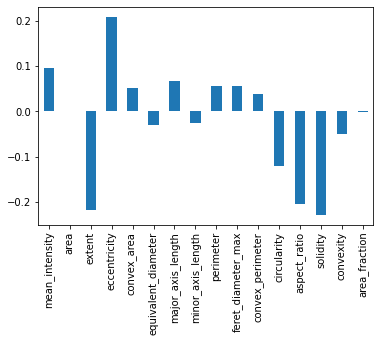

In [ ]:
X.corrwith(y).plot(kind='bar')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
models = {'KNeighborsClassifier':KNeighborsClassifier(),
          'LogisticRegression':LogisticRegression(max_iter=5000),
          'SVC': SVC(),
          'DecisionTreeClassifier':DecisionTreeClassifier(),
          'RandomForestClassifier':RandomForestClassifier(),
          'AdaBoostClassifier':AdaBoostClassifier(),
          'GaussianNB':GaussianNB()
         }
score = []
x=0
#results = pd.DataFrame(y_test)
for name,model in models.items():
    x+=1
    #model.fit(X,y)
   # y_pred = model.predict(X_test)
    cvs = cross_val_score(estimator= model,X= X,y=y,cv=10)
    acc = cvs.mean()
    std = cvs.std()
    #score.append([name,accuracy_score(y_test,y_pred)])
    print(x,'/',len(models),name,round(acc,3),round(std,3))
    score.append([name,acc, std])
    #results[name] = y_pred
score = pd.DataFrame(score, columns=['model name', 'Accuracy','std'])
score.sort_values('Accuracy',ascending=False)

1 / 7 KNeighborsClassifier 0.838 0.029
2 / 7 LogisticRegression 0.822 0.025
3 / 7 SVC 0.798 0.006
4 / 7 DecisionTreeClassifier 0.801 0.018
5 / 7 RandomForestClassifier 0.846 0.021
6 / 7 AdaBoostClassifier 0.834 0.016
7 / 7 GaussianNB 0.474 0.034


,model name,Accuracy,std
4,RandomForestClassifier,0.845891,0.020795
0,KNeighborsClassifier,0.837983,0.028994
5,AdaBoostClassifier,0.834323,0.016098
1,LogisticRegression,0.822203,0.025110
3,DecisionTreeClassifier,0.801312,0.018117
2,SVC,0.797790,0.006229
6,GaussianNB,0.473860,0.034148


# New Section

1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%, 9%, 10%, 11%, 12%, 13%, 14%, 15%, 16%, 17%, 18%, 19%, 20%, 21%, 22%, 23%, 24%, 25%, 26%, 27%, 28%, 29%, 30%, 31%, 32%, 33%, 34%, 35%, 36%, 37%, 38%, 39%, 40%, 41%, 42%, 43%, 44%, 45%, 46%, 47%, 48%, 49%, 50%, 51%, 52%, 53%, 54%, 55%, 56%, 57%, 58%, 59%, 60%, 61%, 62%, 63%, 64%, 65%, 66%, 67%, 68%, 69%, 70%, 71%, 72%, 73%, 74%, 75%, 76%, 77%, 78%, 79%, 80%, 81%, 82%, 83%, 84%, 85%, 86%, 87%, 88%, 89%, 90%, 91%, 92%, 93%, 94%, 95%, 96%, 97%, 98%, 99%, 100%, 

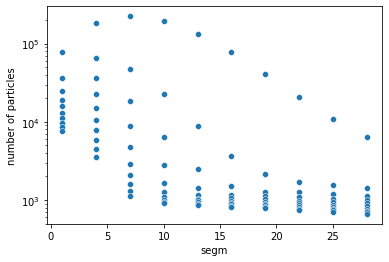

In [ ]:
show_images = False
max_cutoff = 30
min_size = 30
step=3
do_fitting = True
particles = []
counter=0
if show_images and do_fitting:
    plt.imshow(img[1000:1500,500:1000],vmin=0,cmap='gray')
    plt.text(440,30,'img',backgroundcolor='white')
    plt.axis('off')
    plt.show()
if do_fitting:
    for i in range(1,max_cutoff+1,step):
        for j in range(1,min_size+1,step):
            counter+=1
            print(round(counter/((max_cutoff/step)*(min_size/step))*100), end = '%, ')
            img_segm = segmentation(i,6,j,1)
            #img2_label, img2_label_overlay, data_nm = label_img()
            if show_images:
                plt.imshow(img_segm[1000:1500,500:1000],vmin=0,cmap='gray')
                plt.text(450,50,i,backgroundcolor='white')
                plt.axis('off')
                plt.show()
            n_particles = quick_label_img()
            particles.append([i,j,n_particles])
    particles = pd.DataFrame(particles, columns=(['segm','low','number of particles']))

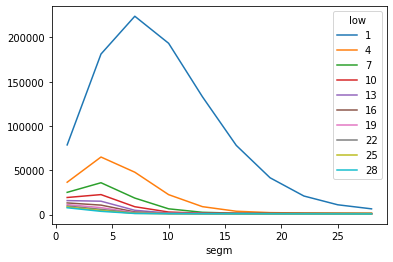

In [ ]:
pd.pivot_table(particles,'number of particles', index='segm',columns='low').plot()

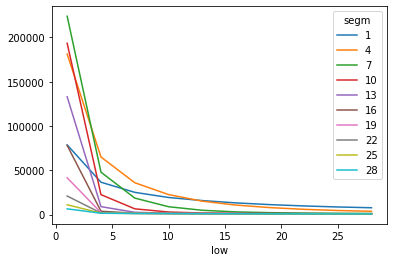

In [ ]:
pd.pivot_table(particles,'number of particles', index='low',columns='segm').plot()

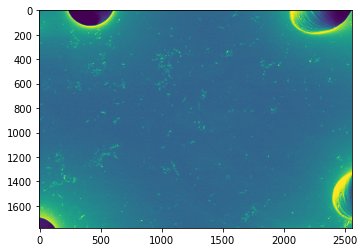

In [ ]:
plt.imshow(img)

# Data presantation

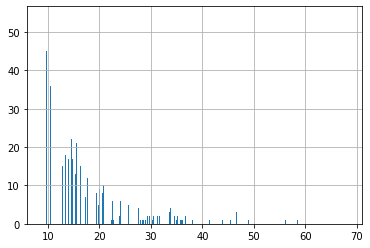

In [ ]:
data_nm['equivalent_diameter'].hist(bins=1000)

In [ ]:
data_nm.sort_values('area',ascending=False).head(10).index

Int64Index([111, 1015, 2800, 2063, 2271, 3193, 3087, 349, 340, 1194], dtype='int64')

In [ ]:
data_nm.iloc[3193]

mean_intensity                                                155.238313
area                                                         6712.624568
convex_area                                                  9536.726013
equivalent_diameter                                            92.448791
major_axis_length                                             142.776171
minor_axis_length                                              71.246973
perimeter                                                     580.857922
feret_diameter_max                                            161.230485
image                  [[False, True, True, True, False, False, False...
convex_image           [[False, True, True, True, True, True, False, ...
img                    [[113, 122, 126, 124, 111, 106, 105, 109, 114,...
convex_perimeter                                              403.349493
circularity                                                     0.500013
aspect_ratio                                       

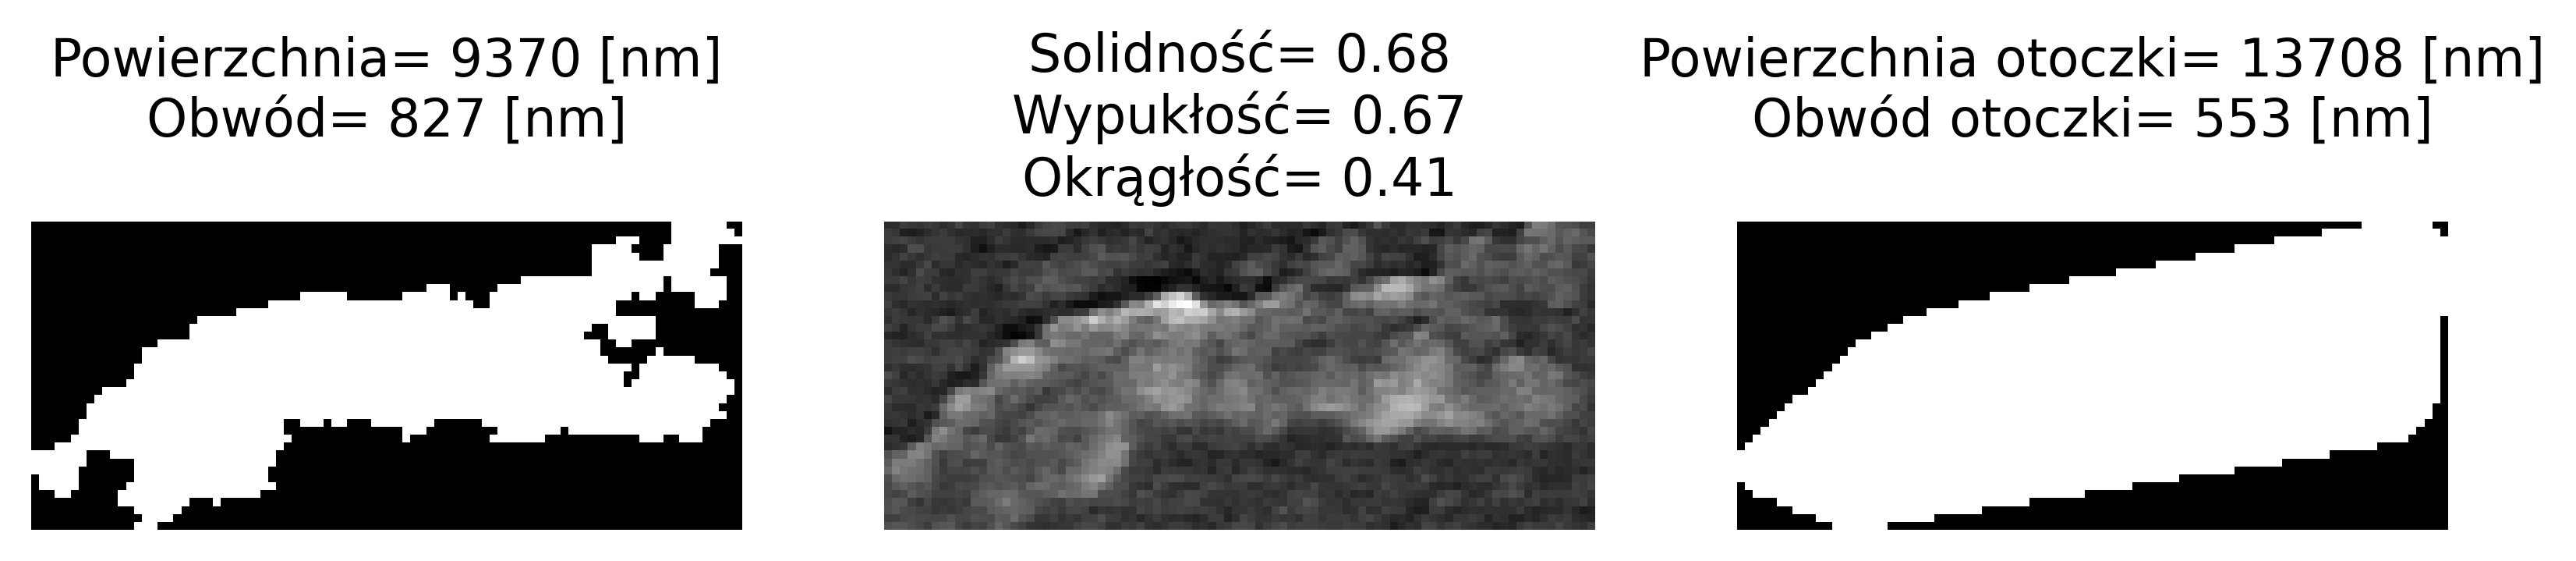

In [ ]:
index=543
plt.figure(figsize=(10,10),dpi=400)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Powierzchnia= '+str(int(data_nm['area'][index]))+' [nm]\n'
          'Obwód= '+str(round(data_nm['perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['image'][index],cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Solidność= '+str(round(data_nm['solidity'][index],2))+'\n'
        'Wypukłość= '+str(round(data_nm['convexity'][index],2))+'\n'
        'Okrągłość= '+str(round(data_nm['circularity'][index],2)))
plt.imshow(data_nm['img'][index],cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Powierzchnia otoczki= '+str(int(data_nm['convex_area'][index]))+' [nm]\n'
           'Obwód otoczki= '+str(round(data_nm['convex_perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['convex_image'][index],cmap='gray')
plt.show()

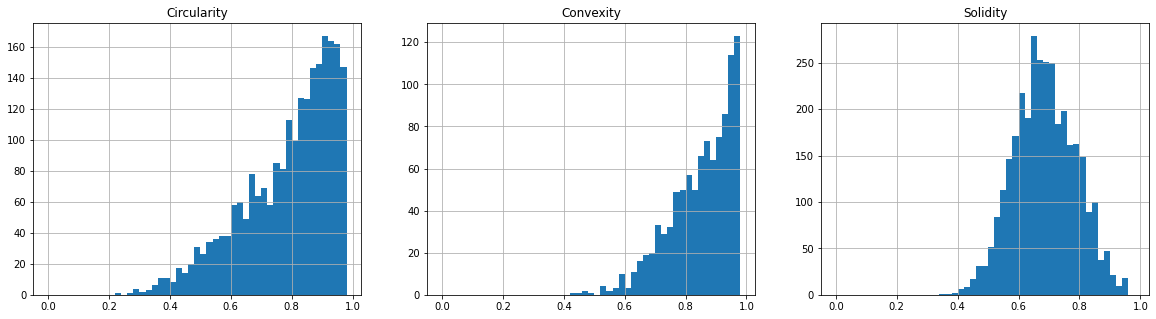

In [ ]:
bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('Circularity')
data_nm['circularity'].hist(bins=bins)

plt.subplot(1,3,2)
plt.title('Convexity')
data_nm['convexity'].hist(bins=bins)

plt.subplot(1,3,3)
plt.title('Solidity')
data_nm['solidity'].hist(bins=bins)